# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [99]:
!ls pnp_dataset.zip || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip)

pnp_dataset.zip


In [100]:
import matplotlib.pyplot as plt

In [101]:
# Run this cell to configure Tensorflow to use your GPU
import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [102]:
from collegium.m02_cnn.utils.pnp_dataset import build_dataset

# See Tensorflow Dataset API for details
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_ds = build_dataset('train', include_labels=True)
score_ds = build_dataset('score', include_labels=False)
train_ds, score_ds

(<_FlatMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>,
 <_FlatMapDataset element_spec=TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None)>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


<tf.Tensor: shape=(), dtype=int32, numpy=1>

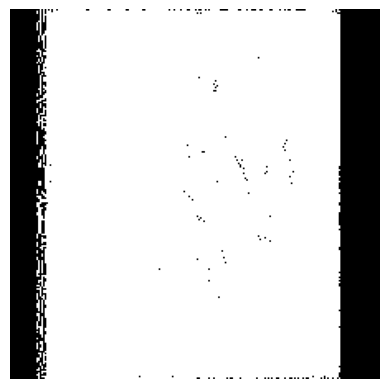

In [103]:
train_sample_x, train_sample_y = next(iter(train_ds))
plt.imshow(train_sample_x)
plt.axis('off')
train_sample_y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


<tf.Tensor: shape=(), dtype=int32, numpy=0>

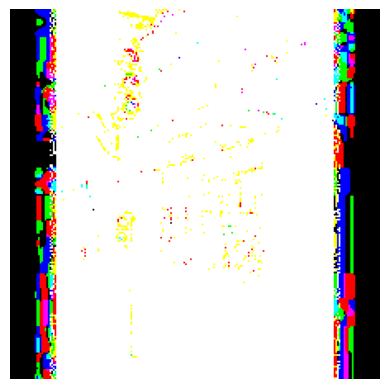

In [104]:
train_sample_x, train_sample_y = next(iter(train_ds.skip(1)))
plt.imshow(train_sample_x)
plt.axis('off')
train_sample_y

In [105]:
#!pip install tensorflow-addons

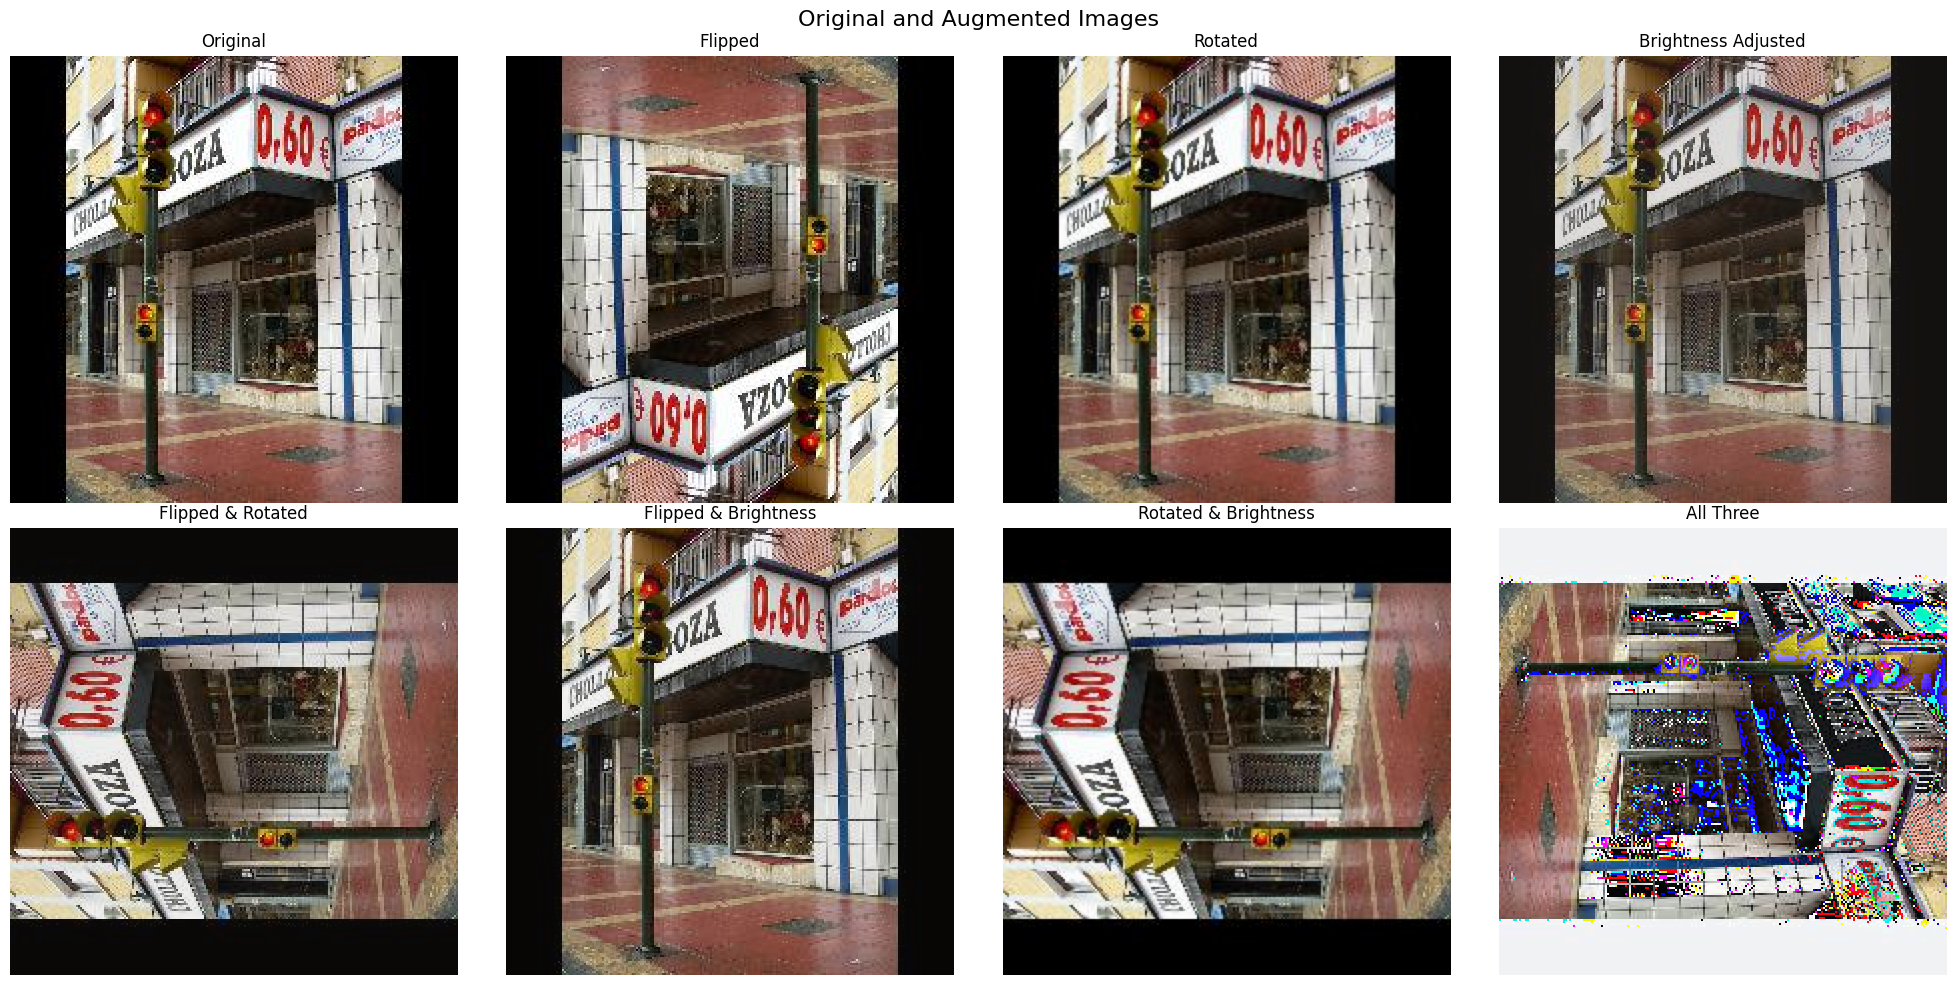

Label: 0


In [106]:
import tensorflow as tf

def random_flip(image):
    return tf.image.random_flip_left_right(image)

import cv2
import numpy as np

def random_rotation(image):
    return tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))


def random_brightness(image):
    return tf.image.random_brightness(image, max_delta=0.2)

def random_contrast(image, lower=0.8, upper=1.2):
    return tf.image.random_contrast(image, lower, upper)



def augment(image, label):
    # Original image
    augmented_images = [image]
    augmented_labels = [label]
    
    
    # Rotate only
    augmented_images.append(random_rotation(image))
    augmented_labels.append(label)
    
    # Brightness only
    augmented_images.append(random_brightness(image))
    augmented_labels.append(label)
    
    # add_gaussian_noise only
    augmented_images.append(random_contrast(image))
    augmented_labels.append(label)
    
    
    
    
    # rotate and noise
    augmented_images.append(random_contrast(random_rotation(image)))
    augmented_labels.append(label)
    
    # brigthness and noise
    augmented_images.append(random_brightness(random_contrast(image)))
    augmented_labels.append(label)
    
    # Rotate and brightness
    augmented_images.append(random_brightness(random_rotation(image)))
    augmented_labels.append(label)
    
    
    #all three
    # Rotate and brightness
    augmented_images.append(random_contrast(random_brightness(random_rotation(image))))
    augmented_labels.append(label)
    
    
    return tf.stack(augmented_images), tf.stack(augmented_labels)

# Visualization code
import matplotlib.pyplot as plt
import numpy as np

# Get a sample image from the dataset
train_sample_x, train_sample_y = next(iter(train_ds.skip(1)))

# Apply augmentations
augmented_images, _ = augment(train_sample_x, train_sample_y)

# Create a figure with subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Original and Augmented Images", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Titles for each subplot
titles = ['Original', 'Flipped', 'Rotated', 'Brightness Adjusted',
          'Flipped & Rotated', 'Flipped & Brightness', 'Rotated & Brightness', 'All Three']

# Plot each image
for i, (ax, image, title) in enumerate(zip(axes, augmented_images, titles)):
    ax.imshow(image.numpy().astype("uint8"))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"Label: {train_sample_y.numpy()}")

In [107]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

In [108]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [109]:
# mobile_net.summary()

In [110]:
model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [111]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 1, 1, 1280)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [112]:


from tensorflow.keras.optimizers import Adam

# Define a low learning rate
learning_rate = 1e-3  # This is equivalent to 0.0001

# Create an Adam optimizer instance with the low learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ],
)

batch_size = 128  # or whatever batch size you decide to use
steps_per_epoch = (80000 * 7) // batch_size

In [113]:
history = model.fit(
    train_ds.batch(batch_size),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    verbose=1 
)

Epoch 1/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 174s 38ms/step - binary_accuracy: 0.5329 - loss: 0.8548  
Epoch 2/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 170s 38ms/step - binary_accuracy: 0.5713 - loss: 0.7387  
Epoch 3/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 167s 38ms/step - binary_accuracy: 0.5930 - loss: 0.6906  
Epoch 4/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 169s 38ms/step - binary_accuracy: 0.6083 - loss: 0.6647  
Epoch 5/5
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 168s 38ms/step - binary_accuracy: 0.6230 - loss: 0.6498  


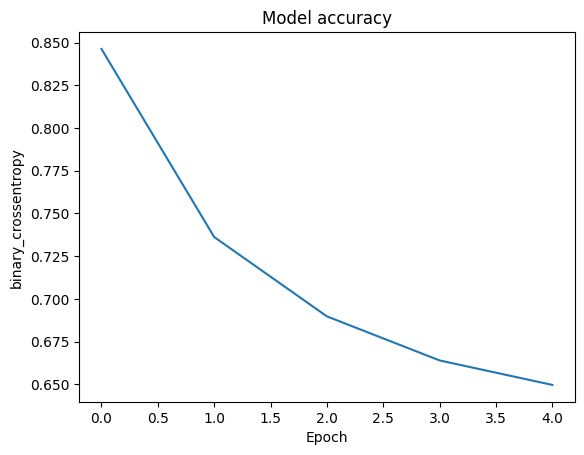

In [114]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

plt.title('Model accuracy')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')

plt.show()

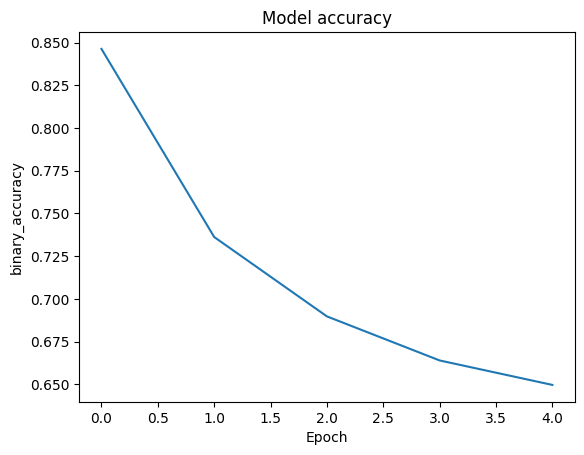

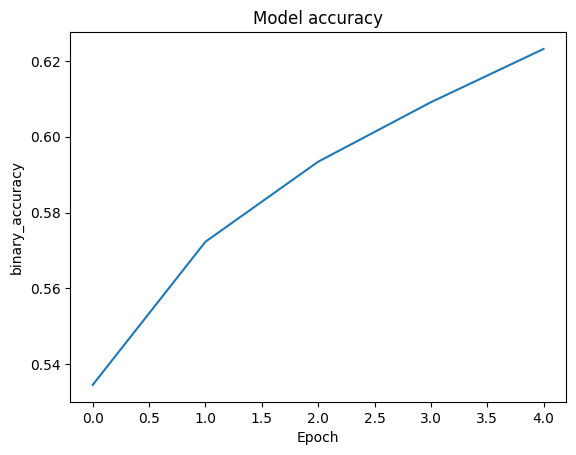

Epoch 1/3
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 175s 38ms/step - binary_accuracy: 0.6034 - loss: 0.7207  
Epoch 2/3
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 168s 38ms/step - binary_accuracy: 0.6384 - loss: 0.6570  
Epoch 3/3
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 169s 38ms/step - binary_accuracy: 0.6560 - loss: 0.6289  


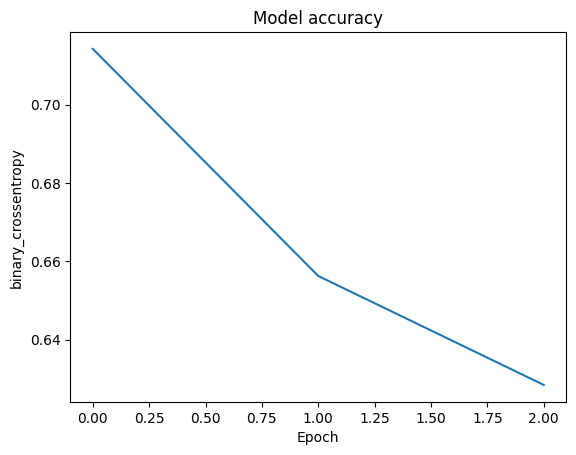

In [117]:
# Unfreeze the last few layers
for layer in mobile_net.layers[-10:]:
    layer.trainable = True

# Define a low learning rate
learning_rate = 1e-5  # This is equivalent to 0.0001

# Create an Adam optimizer instance with the low learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ],
)

batch_size = 128  # or whatever batch size you decide to use
steps_per_epoch = (80000 * 7) // batch_size

history = model.fit(
    train_ds.batch(batch_size),
    epochs=3,
    steps_per_epoch=steps_per_epoch,
    verbose=1 
)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

plt.title('Model accuracy')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')

plt.show()

In [ ]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_ds.batch(batch_size)),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

print(score_y_hat)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')
assert score_y_hat.shape == (20000, 1)

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/model_architecture.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
tf.keras.models.save_model(model, f'{model_dir}/model.keras')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. model_architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset

     79/Unknown 23s 252ms/step

In [ ]:
# Unfreeze the last few layers
for layer in mobile_net.layers[-20:]:
    layer.trainable = True

# Define a low learning rate
learning_rate = 1e-6  # This is equivalent to 0.0001

# Create an Adam optimizer instance with the low learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ],
)

batch_size = 128  # or whatever batch size you decide to use
steps_per_epoch = (80000 * 7) // batch_size

history = model.fit(
    train_ds.batch(batch_size),
    epochs=3,
    steps_per_epoch=steps_per_epoch,
    verbose=1 
)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

plt.title('Model accuracy')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')

plt.show()

In [ ]:
# Finally, unfreeze all layers
mobile_net.trainable = True

# Define a low learning rate
learning_rate = 1e-7  # This is equivalent to 0.0001

# Create an Adam optimizer instance with the low learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ],
)

batch_size = 128  # or whatever batch size you decide to use
steps_per_epoch = (80000 * 7) // batch_size

history = model.fit(
    train_ds.batch(batch_size),
    epochs=3,
    steps_per_epoch=steps_per_epoch,
    verbose=1 
)

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

plt.title('Model accuracy')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')

plt.show()

In [ ]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_ds.batch(batch_size)),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

print(score_y_hat)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')
assert score_y_hat.shape == (20000, 1)

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/model_architecture.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
tf.keras.models.save_model(model, f'{model_dir}/model.keras')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. model_architecture.json -- the model's definition
# 3. model.keras -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset